In [13]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re 
import nltk
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

In [14]:
# reading given stopwords
with open('stopwords_ar.txt', encoding="utf8") as file:
    words = file.readlines()
# remove \n from each line
ar_stopwords = [word[:-1] for word in words]

In [15]:
def preprocess_text(texts):
    clean_text = list()
    for text in texts:
        text = str(text)
        text = re.sub(r'\d',' ',text)    # remove digits
        text = re.sub(r'\\n',' ',text)   # remove new lines to make text as single paragraph. Backslash is used as given text is having backslash noise
        text = re.sub(r'\n',' ',text)    # remove new lines to make text as single paragraph
        text = re.sub(r'\W',' ',text)    # remove all punchuation
        text = re.sub(r'_', ' ', text)   # remove underscore(_)
        re.sub(r'[\"?.>`÷×؛<>_()*&^%ـ،/:"؟.,{}~¦+|!”…“–ـ]', ' ',text)  # remove punchuation
        text = re.sub(r'\s+',' ',text)   # remove extra whitespaces
        
        text = ' '.join(word for word in text.split() if word not in ar_stopwords)
        clean_text.append(text)
    return clean_text

In [16]:
# charlevel function
def charlevel(texts):
    chartext = list()
    for sent in texts:
        char = re.sub(r'\s+','', sent)  # remove whitespace
        char = list(char)  # splitting characters
#         char = list(set(char))
        char = " ".join(w for w in char)
        chartext.append(char)
    return chartext

In [17]:
# ch5gram function
def ch5gram(texts):
    charlevel = list()
#     texts = wordlevel(texts)
    for sent in texts:
        words = list()
        for word in sent.split():
            if len(list(word)) > 5:
                start, end = 0, 4
                parts = math.ceil(len(word)/5)  # finding num of parts to split word
                for i in range(parts):
                    new_word = "".join(w for w in list(word)[start:end])  # making new word by slicing main word
                    words.append(new_word)
                    start = end  # increment indexes for next word
                    end = end+4
            else:
                words.append(word)
        
        words = " ".join(w for w in words)
        charlevel.append(words)
    return charlevel

In [18]:
# wordlevel function
def wordlevel(texts):
    wordtext = list()
    for sent in texts:
        words = sent.split()
        words = " ".join(w for w in words)
        wordtext.append(words)
    return wordtext

### Model

In [19]:
# this function is for finding evaluation metrics of given input 
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction,target_names=label_names))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.2f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.2f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.2f}'.format(f1_score(y_true, prediction, average='weighted') * 100))
    cm = confusion_matrix(y_true,prediction)
    print('\n-----------Confusion Matrix------------\n')
    print(cm)
    
    plt.imshow(cm , cmap= plt.cm.Blues_r)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks,label_names, rotation = 40)
    plt.yticks(tick_marks,label_names)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'.2f'), ha='center', va='center',
                     color='black' if cm[i,j] > thresh else 'white')
    plt.show()

In [199]:
def trainmodel(features, labels):
    # splitting data
    np.random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(features,labels, test_size=0.3, shuffle=True, random_state=42)

    #Defining model
    model = Sequential()
    model.add(Dense(64,input_shape=(features.shape[1],), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Reshape((64,1)))
    model.add(Conv1D(32, kernel_size=3, padding='same', strides=(1)))
    model.add(MaxPooling1D(pool_size=(2), strides=(2), padding= 'valid'))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, kernel_size=3, padding='same', strides=(1)))
    model.add(MaxPooling1D(pool_size=(2), strides=(2), padding= 'valid'))
    model.add(Dropout(0.5))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['accuracy'])
    print(model.summary())
    # training it
    model.fit(x_train,y_train, epochs=25, batch_size=512, validation_data=(x_test,y_test))

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['accuracy'], 'o-')
    ax.plot([None] + model.history.history['val_accuracy'], 'x-')

    ax.legend(['Train_Acc', 'Val_Acc'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + model.history.history['loss'], 'o-')
    ax.plot([None] + model.history.history['val_loss'], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Loss Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Loss')
    plt.show()

    pred = model.predict_classes(x_test)
    report(pred.squeeze(),y_test)

## AAQ Dataset

In [200]:
df = pd.read_csv('dataset/AAQ.csv')
df.head(3)

,sentiment,txt
0,negative,صرماتي براس اهلك
1,negative,حرام السخرية من الناس
2,negative,﻿ طوقان بدور ع منصب يضل فيه عشر سنين لقدام لاس...


In [201]:
text = df.txt
sentiment = df.sentiment
text = preprocess_text(text)

#### CH5 gram method

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 64)                127360    
_________________________________________________________________
dropout_198 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_42 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_199 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 32, 32)          

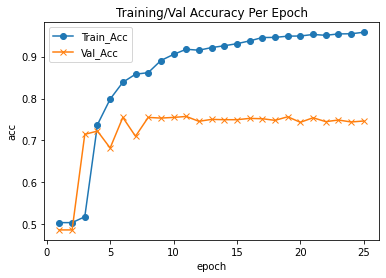

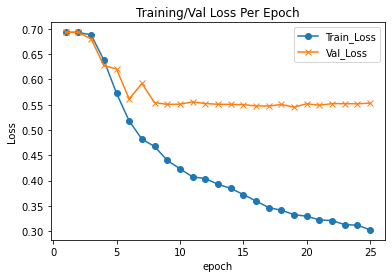

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.76      0.73      0.75       662
    positive       0.73      0.76      0.74       627

    accuracy                           0.75      1289
   macro avg       0.75      0.75      0.75      1289
weighted avg       0.75      0.75      0.75      1289


        ----------Validation Data------------------
Accuarcy: 74.63149728471683
Precision: 74.70 %
Recall-score: 74.63
F1-score: 74.64

-----------Confusion Matrix------------

[[486 176]
 [151 476]]


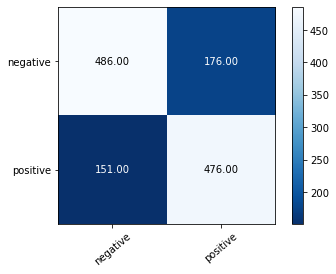

In [203]:
methodtext = ch5gram(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(methodtext)
vect = vectorizer.transform(methodtext).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### Char Level

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 64)                5888      
_________________________________________________________________
dropout_188 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_40 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 64, 32)            352       
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_189 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 32, 32)          

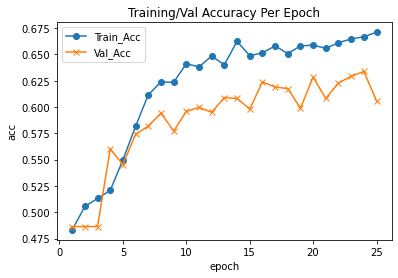

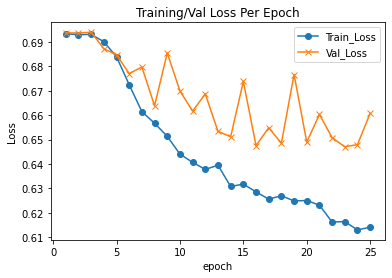

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.59      0.79      0.67       662
    positive       0.65      0.41      0.50       627

    accuracy                           0.61      1289
   macro avg       0.62      0.60      0.59      1289
weighted avg       0.62      0.61      0.59      1289


        ----------Validation Data------------------
Accuarcy: 60.589604344453065
Precision: 61.81 %
Recall-score: 60.59
F1-score: 59.00

-----------Confusion Matrix------------

[[526 136]
 [372 255]]


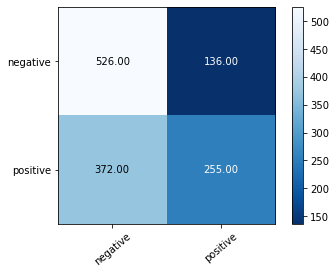

In [197]:
methodtext = charlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='char')
vectorizer.fit(methodtext)
vect = vectorizer.transform(methodtext).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### Word Level

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 64)                79488     
_________________________________________________________________
dropout_193 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 64, 32)            352       
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 32, 32)          

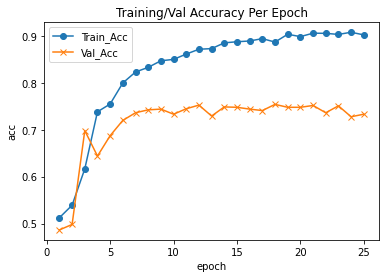

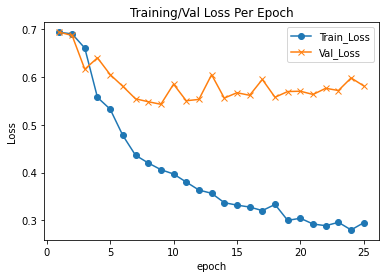

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.75      0.72      0.73       662
    positive       0.72      0.75      0.73       627

    accuracy                           0.73      1289
   macro avg       0.73      0.73      0.73      1289
weighted avg       0.73      0.73      0.73      1289


        ----------Validation Data------------------
Accuarcy: 73.31264546159814
Precision: 73.39 %
Recall-score: 73.31
F1-score: 73.32

-----------Confusion Matrix------------

[[476 186]
 [158 469]]


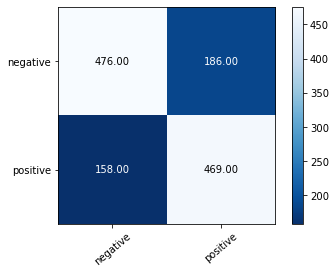

In [198]:
methodtext = wordlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

## AJGT Dataset

In [177]:
df = pd.read_csv('dataset/AJGT.csv')
df.head(3)

,ID,text,polarity
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,2,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,3,كله رائع بجد ربنا يكرمك,Positive


In [178]:
text = df.text
sentiment = df.polarity
text = preprocess_text(text)

#### Char Level

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 64)                2176      
_________________________________________________________________
dropout_148 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_32 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 32, 32)          

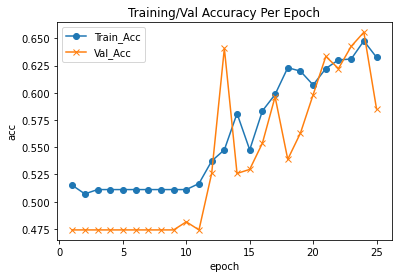

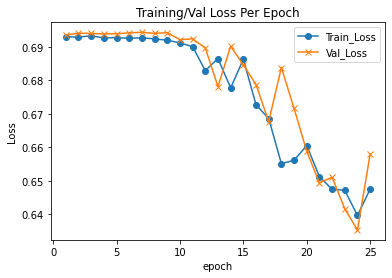

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.72      0.21      0.32       256
    Positive       0.56      0.93      0.70       284

    accuracy                           0.59       540
   macro avg       0.64      0.57      0.51       540
weighted avg       0.64      0.59      0.52       540


        ----------Validation Data------------------
Accuarcy: 58.51851851851851
Precision: 63.64 %
Recall-score: 58.52
F1-score: 52.11

-----------Confusion Matrix------------

[[ 53 203]
 [ 21 263]]


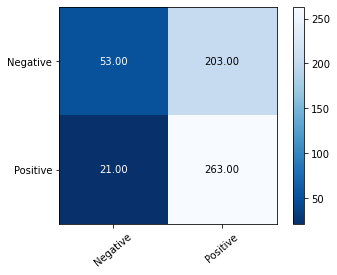

In [179]:
methodtext = charlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='char')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### CH5 gram method

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                101568    
_________________________________________________________________
dropout_153 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_33 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_154 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 32, 32)          

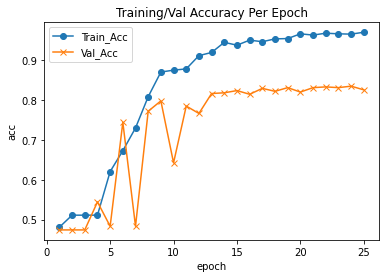

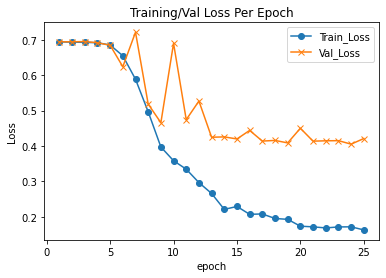

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.78      0.89      0.83       256
    Positive       0.88      0.77      0.82       284

    accuracy                           0.83       540
   macro avg       0.83      0.83      0.83       540
weighted avg       0.83      0.83      0.83       540


        ----------Validation Data------------------
Accuarcy: 82.5925925925926
Precision: 83.30 %
Recall-score: 82.59
F1-score: 82.58

-----------Confusion Matrix------------

[[227  29]
 [ 65 219]]


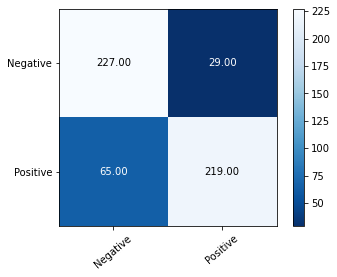

In [180]:
methodtext = ch5gram(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### Word Level

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                101568    
_________________________________________________________________
dropout_158 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_34 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 32, 32)          

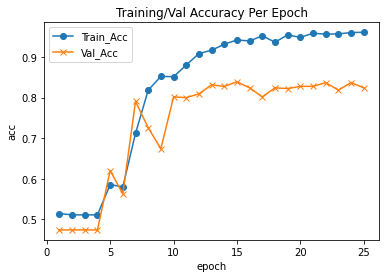

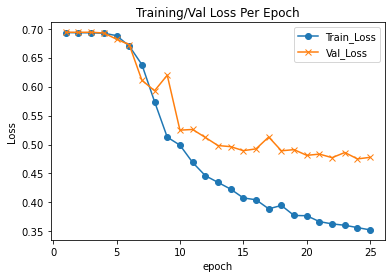

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    Negative       0.79      0.85      0.82       256
    Positive       0.85      0.80      0.83       284

    accuracy                           0.82       540
   macro avg       0.82      0.83      0.82       540
weighted avg       0.83      0.82      0.82       540


        ----------Validation Data------------------
Accuarcy: 82.4074074074074
Precision: 82.59 %
Recall-score: 82.41
F1-score: 82.42

-----------Confusion Matrix------------

[[217  39]
 [ 56 228]]


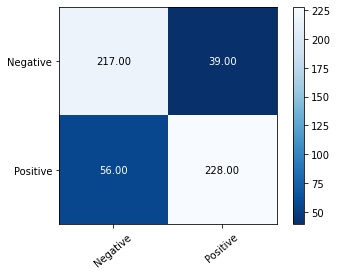

In [181]:
methodtext = wordlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

## ArTwitter Dataset

In [182]:
df = pd.read_csv('dataset/ArTwitter.csv')
df.head(3)

,sentiment,txt
0,positive,انشاء الله هنعمل حاجه
1,negative,اقسم باللله ان العرب اكثر الشعوب تخلفاا
2,negative,﻿هات ناس تفهم .. و المثل بحكي اسأل مجرب و لا ت...


In [183]:
text = df.txt
sentiment = df.sentiment
text = preprocess_text(text)

#### Char Level

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 64)                5120      
_________________________________________________________________
dropout_163 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_35 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_164 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 32, 32)          

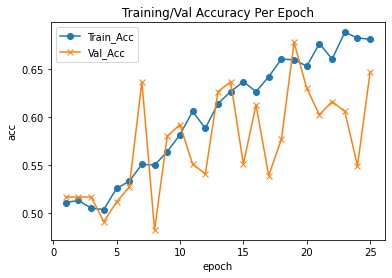

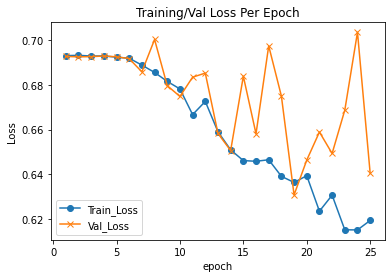

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.59      0.88      0.71       283
    positive       0.80      0.43      0.55       303

    accuracy                           0.65       586
   macro avg       0.69      0.65      0.63       586
weighted avg       0.70      0.65      0.63       586


        ----------Validation Data------------------
Accuarcy: 64.67576791808874
Precision: 69.65 %
Recall-score: 64.68
F1-score: 62.84

-----------Confusion Matrix------------

[[250  33]
 [174 129]]


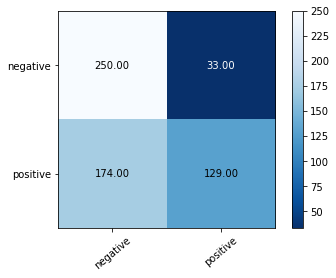

In [184]:
methodtext = charlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='char')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### CH5 gram method

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 64)                114176    
_________________________________________________________________
dropout_168 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_36 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_169 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 32, 32)          

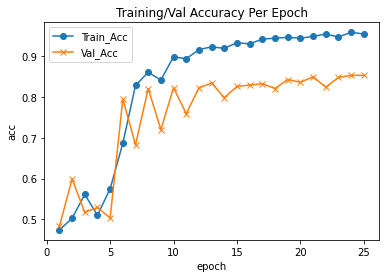

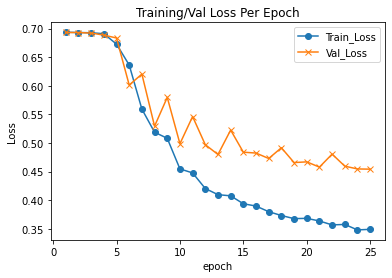

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.80      0.92      0.86       283
    positive       0.91      0.79      0.85       303

    accuracy                           0.85       586
   macro avg       0.86      0.86      0.85       586
weighted avg       0.86      0.85      0.85       586


        ----------Validation Data------------------
Accuarcy: 85.32423208191126
Precision: 86.06 %
Recall-score: 85.32
F1-score: 85.29

-----------Confusion Matrix------------

[[260  23]
 [ 63 240]]


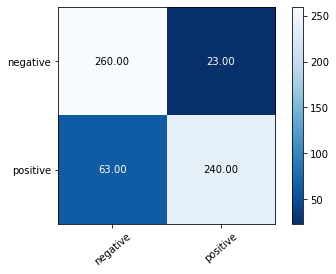

In [185]:
methodtext = ch5gram(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)

#### Word Level

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 64)                114176    
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 32, 32)            0         
_________________________________________________________________
dropout_174 (Dropout)        (None, 32, 32)            0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 32, 32)          

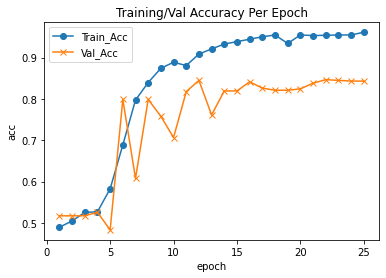

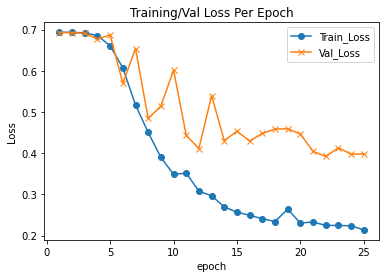

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

    negative       0.80      0.89      0.85       283
    positive       0.89      0.80      0.84       303

    accuracy                           0.84       586
   macro avg       0.85      0.84      0.84       586
weighted avg       0.85      0.84      0.84       586


        ----------Validation Data------------------
Accuarcy: 84.30034129692832
Precision: 84.77 %
Recall-score: 84.30
F1-score: 84.28

-----------Confusion Matrix------------

[[253  30]
 [ 62 241]]


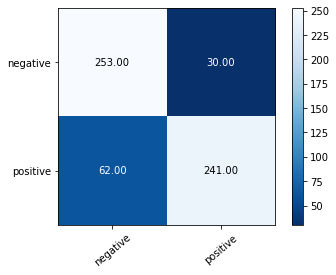

In [186]:
methodtext = wordlevel(text)

vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9, stop_words=None, analyzer='word')
vectorizer.fit(text)
vect = vectorizer.transform(text).toarray()

le = LabelEncoder()
y = le.fit_transform(sentiment)
# class names
label_names = le.classes_

trainmodel(vect,y)